In [1]:
import math
import os
import pandas as pd
import numpy as np
import copy
import sys
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
sys.path.append("/Users/peterpriestley/hmf/repos/scripts/analysisscripts") 
import chromosomeDefinition as cd
import analyseVCF as aVCF
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
%pprint

Pretty printing has been turned OFF


In [2]:
CNV_COLUMNS = ['chrom','posStart','posEnd','copyNum','gainOrLoss','BAF','score','germlineOrSomatic','oneOrZero']

In [3]:
# LOAD BED
BED_PATH = "/Users/peterpriestley/hmf/analyses/slices/"
BED_FILE_NAME = "cosmicCurated.bed" 
BED_FILE_NAME = "cosmicCancerCensus.bed"
BED_PATH = "/Users/peterpriestley/hmf/analyses/giabTruthsets/"
BED_FILE_NAME = "NA12878_GIAB_highconf_IllFB-IllGATKHC-CG-Ion-Solid_ALLCHROM_v3.2.2_highconf.bed"
#BED_FILE_NAME = "CPCT_Slicing.bed"
USE_BED = True
LOAD_FULL_FILE = True

### FUNCTIONS

In [4]:
def findFiles(path,suffix):
    files=[]
    for x in os.listdir(path):
        if x[-len(suffix):] == suffix:
            files.append(x)
    return files

In [5]:
def loadCNVforPatient(cnvFile,patientName):
    dfCNV = pd.read_table(cnvFile, names = CNV_COLUMNS )
    #print dfCNV
    #add regions with default copy number
    last = dfCNV.iloc[0]
    for i in range(1, dfCNV.shape[0]-1):
        #print last.chrom,last.posStart,last.posEnd
        if last['posEnd']<>dfCNV.iloc[i]['posStart']:
            if last['chrom']==dfCNV.iloc[i]['chrom']:
                dfCNV.loc[len(dfCNV)] = [last['chrom'],last['posEnd'], dfCNV.iloc[i]['posStart']-1,2,'none','-','-','-','-']
            else:
                dfCNV.loc[len(dfCNV)] = [last['chrom'],last['posEnd'], cd.chromosomeLength[last['chrom']],2,'none','-','-','-','-']
                if dfCNV.iloc[i]['posStart']<>0:
                    dfCNV.loc[len(dfCNV)] = [dfCNV.iloc[i]['chrom'],0, dfCNV.iloc[i]['posStart'],2,'none','-','-','-','-']
        last = dfCNV.iloc[i]
    #fix first record
    if dfCNV.iloc[0]['posStart']<>0:
        dfCNV.loc[len(dfCNV)] = ['1',0, dfCNV.iloc[0]['posStart'],2,'none','-','-','-','-']
    #Additional Fields
    dfCNV['chromPos']= dfCNV['chrom'].apply(lambda x: cd.intChrom(x)) + dfCNV['posStart'] / dfCNV['chrom'].apply(lambda x: cd.chromosomeLength[str(x)])
    dfCNV['chrom'] = dfCNV['chrom'].apply(lambda x: cd.intChrom(x))
    dfCNV['cappedCopyNum'] = dfCNV['copyNum'].clip(upper=5)
    dfCNV = dfCNV.sort_values(["chrom","posStart","posEnd"]).reset_index()
    dfCNV['regionLength'] = (dfCNV['posEnd']-dfCNV['posStart'])
    dfCNV['patientName']=patientName
    return dfCNV

In [6]:
def calculateSomaticCNV(dfTumorCNV):
    lastSomaticCopyNum = 2
    dfTumorCNV['copyNumSomatic']= dfTumorCNV['copyNum']
    for i in range(1, dfTumorCNV.shape[0]-1):
        if dfTumorCNV.iloc[i].germlineOrSomatic=="germline":
                dfTumorCNV.ix[i,'copyNumSomatic'] = lastSomaticCopyNum
        elif dfTumorCNV.iloc[i].germlineOrSomatic=="somatic"  or dfTumorCNV.iloc[i].germlineOrSomatic=="-":  
            lastSomaticCopyNum = dfTumorCNV.ix[i,'copyNumSomatic']
    return dfTumorCNV

In [7]:
def calculateCleanCNV(dfTumorCNV):
    lastSomaticCopyNum = 2
    dfTumorCNV['copyNumClean']= dfTumorCNV['copyNum']
    for i in range(1, dfTumorCNV.shape[0]-1):
        if (dfTumorCNV.iloc[i].normalRatio < 0.7 and dfTumorCNV.iloc[i].gainOrLoss=='loss' and dfTumorCNV.iloc[i].tumorRatio/dfTumorCNV.iloc[i].normalRatio>0.1) or \
            (dfTumorCNV.iloc[i].normalRatio>1.4 and dfTumorCNV.iloc[i].gainOrLoss=='gain' and dfTumorCNV.iloc[i].tumorRatio/dfTumorCNV.iloc[i].normalRatio<1.4) or \
            dfTumorCNV.iloc[i].germlineOrSomatic=="germline":
                dfTumorCNV.ix[i,'copyNumClean'] = lastSomaticCopyNum
        elif dfTumorCNV.iloc[i].germlineOrSomatic=="somatic" or dfTumorCNV.iloc[i].germlineOrSomatic=="-":  
            lastSomaticCopyNum = dfTumorCNV.ix[i,'copyNumClean']
    return dfTumorCNV

In [8]:
def cleanNONBAFregionsCNV(dfTumorCNV):
    ### LOGIC
    # If regionLength < x 
    # AND BAF = "-" 
    # AND previous and next adjacent regions have the same cleaned copy number 
    # AND the copyNum <> previous Copy NUM and 
    # AND copyNUM BETWEEN previousCopyNUM +/- 51%
    # THEN REMOVE REGION AND MAKE ALL 3 REGIONS ONE REGION.
    lastCleanCopyNum = 2
    lastChrom = 1
    dfTumorCNV['copyNumCleanNonBAFRemoved']= dfTumorCNV['copyNumClean']
    for i in range(1, dfTumorCNV.shape[0]-1):
        if lastChrom <> dfTumorCNV.iloc[i].chrom:
            lastCleanCopyNum = 2
            lastChrom = dfTumorCNV.ix[i,'chrom']
        elif ((dfTumorCNV.iloc[i].BAF == "-" or dfTumorCNV.iloc[i].nonZeroCount < 20) and \
            dfTumorCNV.iloc[i].copyNumClean<lastCleanCopyNum*1.35 and dfTumorCNV.iloc[i].copyNumClean > lastCleanCopyNum*0.65) \
            or (dfTumorCNV.iloc[i].nonZeroCount < 10 and dfTumorCNV.iloc[i].copyNumClean<lastCleanCopyNum*1.51 and \
            dfTumorCNV.iloc[i].copyNumClean > lastCleanCopyNum*0.49) \
            or (dfTumorCNV.iloc[i].nonZeroCount < 100 and \
            (dfTumorCNV.iloc[i].ratioOfRatio*2<lastCleanCopyNum*1.25 and dfTumorCNV.iloc[i].ratioOfRatio*2> lastCleanCopyNum*0.8)) \
            or abs(lastCleanCopyNum-dfTumorCNV.iloc[i].ratioOfRatio*2) < abs(dfTumorCNV.iloc[i].copyNumClean-dfTumorCNV.iloc[i].ratioOfRatio*2):
#            or (dfTumorCNV.iloc[i].ratioOfRatio*2 <lastCleanCopyNum and lastCleanCopyNum < dfTumorCNV.iloc[i].copyNumClean) \
#            or (dfTumorCNV.iloc[i].ratioOfRatio*2 >lastCleanCopyNum and lastCleanCopyNum > dfTumorCNV.iloc[i].copyNumClean) ):
                dfTumorCNV.ix[i,'copyNumCleanNonBAFRemoved'] = lastCleanCopyNum
        elif dfTumorCNV.iloc[i].germlineOrSomatic=="somatic" or dfTumorCNV.iloc[i].germlineOrSomatic=="-": 
            lastCleanCopyNum = dfTumorCNV.ix[i,'copyNumCleanNonBAFRemoved']
            lastChrom = dfTumorCNV.ix[i,'chrom']
    return dfTumorCNV

In [9]:
def positionChart(dfCNV,filename,fieldName,minChrom=1,maxChrom=23,maxValue=10):
    plt.figure(figsize=[18,3])
    plt.title(filename+" "+fieldName)
    ax = plt.gca()
    ax.plot(dfCNV['chromPos'], dfCNV[fieldName],drawstyle="steps-post")
    ax.axis([minChrom, maxChrom, 0, maxValue])

In [10]:
def pdfChart(log_dens,maxYValue=8):
    fig, ax = plt.subplots()
    ax.plot(X_plot[:, 0], np.exp(log_dens), '-',
            label="kernel = '{0}'".format('gaussian'))
    ax.legend(loc='upper right')
    fig.set_figwidth(10)
    fig.set_figheight(3)
    ax.set_ylim(-0.02, maxYValue)
    ax.grid(b=True, which='both', color='0.65',linestyle='-')
    plt.show()

In [11]:
def cnvLabel(copyNumber):
    if copyNumber < 2:
        return 'loss'
    elif copyNumber > 2:
        return 'amplification'
    else:
        return'normal'

In [12]:
def nonZeroCountBetween(chrom,minPos,maxPos):
    temp = dfTumorRatio[(dfTumorRatio.Chromosome==chrom)&(dfTumorRatio.Start>minPos)&\
                       (dfTumorRatio.Start<maxPos)&(dfTumorRatio.Ratio_x<>-1)]
    return temp['Start'].count(),temp['Ratio_x'].mean(),temp['Ratio_y'].mean(),temp['MedianRatio_x'].mean(),temp['MedianRatio_y'].mean()

In [13]:
def fitBAFPeak(mBAF):
    return min(mBAFPeaks, key=lambda x:abs(x-mBAF))

def fitCNVPeak(ratio):
    return min(cnvPeaks, key=lambda x:abs(x-ratio))

In [58]:
def runGeneCNVAnalysis(dfCNV,bed,patientName):
    geneList =[]
    for bedrow in bed:
        bedChromPosStart = cd.intChrom(bedrow[0]) + float(bedrow[1])/cd.chromosomeLength[bedrow[0]]
        bedChromPosEnd = cd.intChrom(bedrow[0]) + float(bedrow[1])/cd.chromosomeLength[bedrow[0]]
        prevCNV = max(dfCNV[(dfCNV['chromPos'] < bedChromPosStart)].index.tolist())
        if dfCNV[(dfCNV['chromPos'] > bedChromPosEnd) ].index.tolist():
            nextCNV = min(dfCNV[(dfCNV['chromPos'] > bedChromPosEnd) ].index.tolist())
            minCopyNum = min(([dfCNV.iloc[x]['myCopyNum']]) for x in range (prevCNV,nextCNV)) 
        else:
            minCopyNum = [-1]
        geneList.append([patientName,bedrow[3],bedrow[0],bedrow[1],bedrow[2],minCopyNum[0],cnvLabel(minCopyNum[0])])
    return geneList

In [15]:
def patientIDFromFilename(filename):
    patientIDStart = filename.find("CPCT02")
    return filename[patientIDStart:patientIDStart+12]

In [16]:
def loadBAFData(bafFile):
    df = pd.read_table(bafFile)
    return df

In [17]:
def loadVCF(path,filename,sampleNames,patientID):
    df = pd.DataFrame()
    if USE_BED:
        bed = aVCF.loadBEDFile(BED_PATH,BED_FILE_NAME)
        return pd.concat([df,aVCF.loadVariantsFromVCF(path,filename,sampleNames,patientID,True,True,bed,LOAD_FULL_FILE)])
    else:
        return pd.concat([df,aVCF.loadVariantsFromVCF(path,filename,sampleNames,patientID,True)])

In [18]:
def calculateMBAFBetween(chrom,minPos,maxPos):
    dftemp = dfBAF[(dfBAF.Chromosome==chrom)&(dfBAF.Position>minPos)&(dfBAF.Position<maxPos)]
    return dftemp['mBAF'].median(),dftemp['mBAF'].count()

In [19]:
def createBAF(dfGermline):
    dfBAF = dfGermline[(dfGermline['variantType']=="SNP")&(dfGermline['normalSGT']=="0/1")&(dfGermline['normalAF']>0.4) \
                   &(dfGermline['normalAF']<0.65)&(dfGermline['normalDP']>30)&\
                   (dfGermline['normalDP']<40)][['chrom','pos','tumorAF']]
    dfBAF.columns = ['Chromosome', 'Position','BAF']
    dfBAF['Position'] = pd.to_numeric(dfBAF['Position'])
    dfBAF['mBAF']= 0.5+abs(dfBAF['BAF']-0.5)
    dfBAF['chromPos']= dfBAF['Chromosome'].apply(lambda x: cd.intChrom(x)) + dfBAF['Position'] / dfBAF['Chromosome'].apply(lambda x: cd.chromosomeLength[str(x)])
    dfBAF['Chromosome']= dfBAF['Chromosome'].apply(lambda x: cd.intChrom(x))
    return dfBAF

In [20]:
def loadPON(aPath,aPONFile):
    myPON = []
    with open(aPath + aPONFile, 'r') as f:
        for line in f:
            line = line.strip('\n')
            splitLine = line.split('\t')
            myPON.append(splitLine)
    dfPON = pd.DataFrame(myPON)
    dfPON.columns = ['chrom','pos','ref','alt','PONCount']
    return dfPON

In [21]:
def AFByPosPlot(pos,AF,startChartPos,endChartPos):
    plt.figure(figsize=[18,3])
    plt.scatter(pos, AF)
    plt.grid(b=True, which='both', color='0.65',linestyle='-')
    plt.axis([startChartPos, endChartPos,0, 1.0])
    plt.show()

In [22]:
def findPeaks(log_dens,X_range):
    peaks = []
    troughs = []
    dens=np.exp(log_dens)
    diff = [dens[x] - dens[x-1] for x in range(1,len(dens))]
    for i in range (len(diff)-1):
        if diff[i+1] < 0 and diff[i] > 0:
            peaks.append(float(i+1)/len(dens)*X_range)
        if diff[i+1] > 0 and diff[i] < 0:
            troughs.append(float(i+1)/len(dens)*X_range)
    return peaks#, troughs

### LOAD PON

In [59]:
# Only needs to be run once
dfPON = loadPON("/Users/peterpriestley/hmf/analyses/PON/779filePON/","PON.tsv")

### ANALYSIS

In [30]:
PATH="/Users/peterpriestley/hmf/analyses/v1.12samples/CPCT02010292/"
tumorCNVFileName=findFiles(PATH,"gz_CNVs")[0]
normalCNVFileName=findFiles(PATH,"normal_CNVs")[0]
tumorRatioFileName=findFiles(PATH,"gz_ratio.txt")[0]
normalRatioFileName=findFiles(PATH,"gz_normal_ratio.txt")[0]
somaticVCFFilename = findFiles(PATH,"melted.vcf")[0]
germlineVCFFilename = findFiles(PATH,"SLICED.vcf")[0]
patientID = patientIDFromFilename(germlineVCFFilename)
print "germline =",germlineVCFFilename
print "patient =",patientID
print "CNV =",tumorCNVFileName

germline = 170324_HMFregCPCT_FR10303427_FR10244753_CPCT02010292.annotatedSLICED.vcf
patient = CPCT02010292
CNV = CPCT02010292TII_dedup.realigned.pileup.gz_CNVs


In [34]:
dfGermline = loadVCF(PATH,germlineVCFFilename,{patientID+'R':'normal',patientID+'T':'tumor'},patientID)
dfSomatic = loadVCF(PATH,somaticVCFFilename,{patientID+'T':'melted'},patientID)

reading vcf file: 170324_HMFregCPCT_FR10303427_FR10244753_CPCT02010292.annotatedSLICED.vcf
reading VCF File line: 1
reading VCF File line: 200001
Number variants loaded: 344088
reading vcf file: CPCT02010292R_CPCT02010292TII_melted.vcf
reading VCF File line: 1
Number variants loaded: 59221


In [25]:
# APPLY PON to SOMATICs
dfSomatic['alt'] = dfSomatic['meltedallele']
dfSomatic = pd.merge(dfSomatic,dfPON,how='left', on=['chrom','pos','ref','alt'])
dfSomatic['PONCount'].fillna(0, inplace=True)
dfSomatic['inPON'] = pd.to_numeric(dfSomatic.PONCount,errors=coerce)>4

NameError: name 'dfSomatic' is not defined

In [35]:
dfBAF = createBAF(dfGermline)

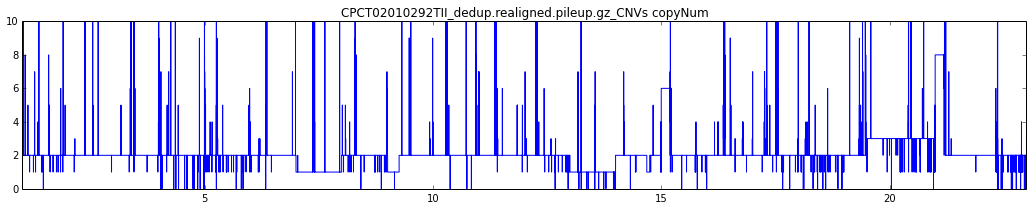

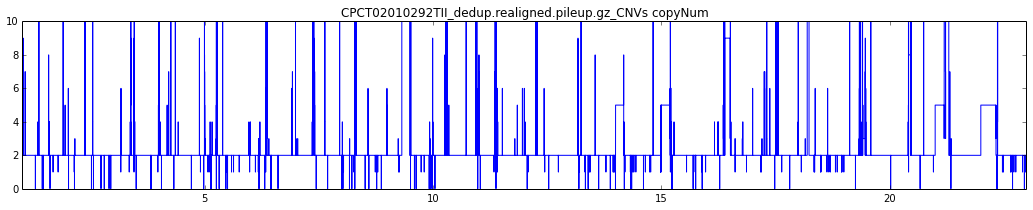

In [36]:
patientName=normalCNVFileName[:12]
dfTumorCNV = loadCNVforPatient(PATH+tumorCNVFileName,patientName)
dfNormalCNV = loadCNVforPatient(PATH+normalCNVFileName,patientName)
positionChart(dfTumorCNV,tumorCNVFileName,"copyNum")
positionChart(dfNormalCNV,tumorCNVFileName,"copyNum")


In [37]:
dfTumorCNV['mBAF'], dfTumorCNV['mBAFCount'] = \
    np.vectorize(calculateMBAFBetween)(dfTumorCNV['chrom'], dfTumorCNV['posStart'],dfTumorCNV['posEnd'])

### Ratio calculations

In [38]:
dfTumorRatio = pd.read_table(PATH + tumorRatioFileName, header=0)#names = ['chrom','window',"ratio","segmentRatio","copyNum","mbaf","baf","GT","uncertainty"] )
dfNormalRatio = pd.read_table(PATH + normalRatioFileName, header=0)# names = ['chrom','window',"ratio","segmentRatio","copyNum","mbaf","baf","GT","uncertainty"] )
dfTumorRatio.set_index(['Chromosome','Start'],inplace=True)
dfNormalRatio.set_index(['Chromosome','Start'],inplace=True)
dfTumorRatio = pd.merge(dfTumorRatio,dfNormalRatio,how='inner', left_index=True,right_index=True)
#dfTumorRatio = dfTumorRatio[(dfTumorRatio.Ratio_y > 0)]
dfTumorRatio['ratio']= pd.to_numeric(dfTumorRatio['Ratio_x'],errors=coerce) /pd.to_numeric(dfTumorRatio['Ratio_y'],errors=coerce)
dfTumorRatio = dfTumorRatio.reset_index()
dfTumorRatio['chromPos'] = dfTumorRatio['Chromosome'].apply(lambda x: cd.intChrom(str(x))) + \
    dfTumorRatio['Start']/dfTumorRatio['Chromosome'].map(lambda x: cd.chromosomeLength[str(x)])
dfTumorRatio['Chromosome'] = dfTumorRatio['Chromosome'].apply(lambda x: cd.intChrom(str(x)))

/Library/Python/2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [39]:
dfTumorCNV['nonZeroCount'],dfTumorCNV['tumorRatio'],dfTumorCNV['normalRatio'] \
    ,dfTumorCNV['tumorMedianRatio'],dfTumorCNV['normalMedianRatio'] = \
    np.vectorize(nonZeroCountBetween)(dfTumorCNV['chrom'], dfTumorCNV['posStart'],dfTumorCNV['posEnd'])
dfTumorCNV['ratioOfRatio']=dfTumorCNV.tumorRatio/dfTumorCNV.normalRatio

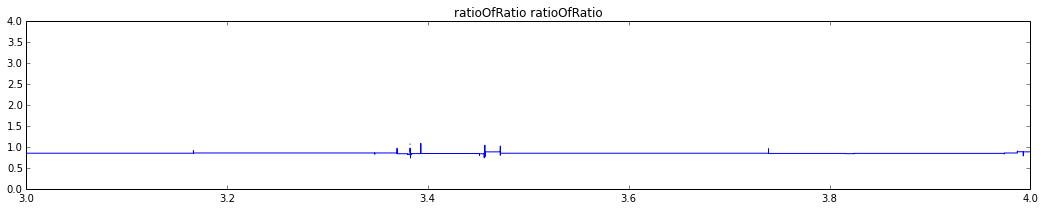

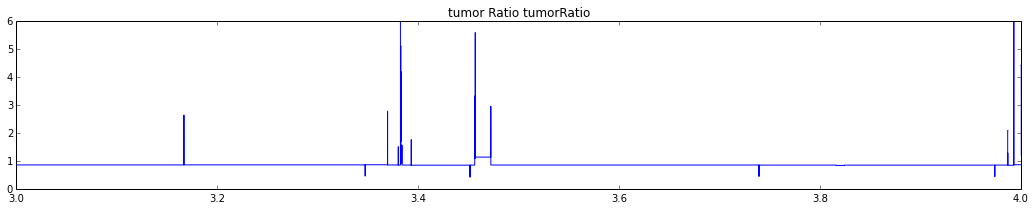

In [63]:
positionChart(dfTumorCNV,"ratioOfRatio","ratioOfRatio",3,4,4)
positionChart(dfTumorCNV,"tumor Ratio","tumorRatio",3,4,6)

### CLEANING ANALYSIS

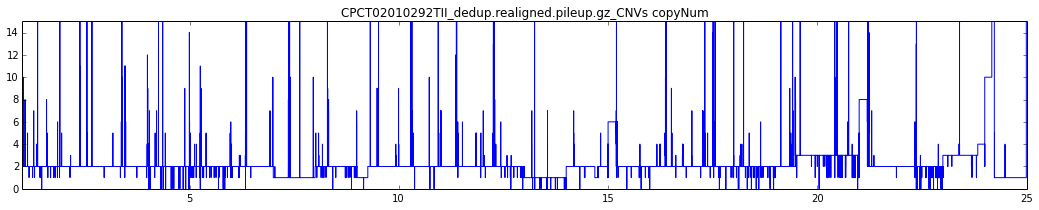

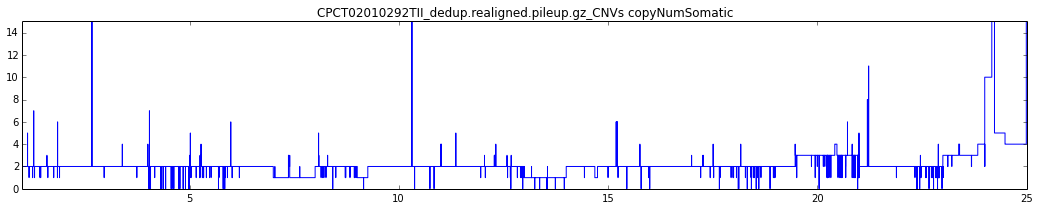

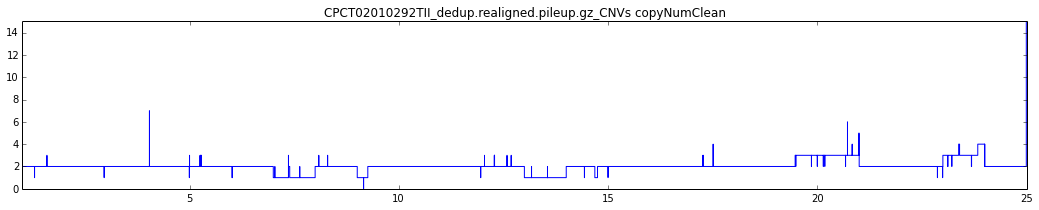

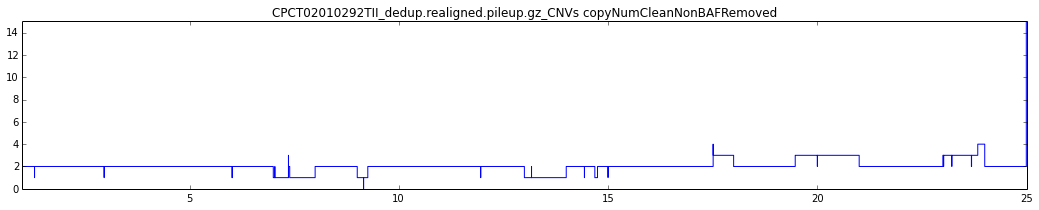

In [41]:
dfTumorCNV = calculateSomaticCNV(dfTumorCNV)
dfTumorCNV = calculateCleanCNV(dfTumorCNV)
dfTumorCNV = cleanNONBAFregionsCNV(dfTumorCNV)
positionChart(dfTumorCNV,tumorCNVFileName,"copyNum",1,25,15)
positionChart(dfTumorCNV,tumorCNVFileName,"copyNumSomatic",1,25,15)
positionChart(dfTumorCNV,tumorCNVFileName,"copyNumClean",1,25,15)
positionChart(dfTumorCNV,tumorCNVFileName,"copyNumCleanNonBAFRemoved",1,25,15)

### PEAK FINDING

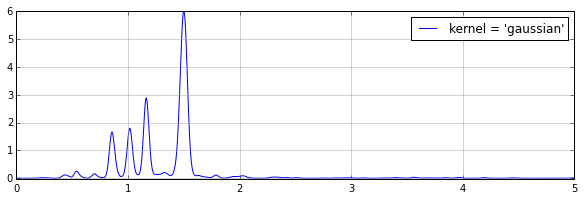

[0.22999999999999998, 0.43499999999999994, 0.54, 0.7000000000000001, 0.8550000000000001, 1.0150000000000001, 1.1600000000000001, 1.3250000000000002, 1.5, 1.6300000000000001, 1.785, 1.9500000000000002, 2.0250000000000004, 2.295, 2.33, 2.42, 2.505, 2.745, 2.8549999999999995, 2.945, 3.005, 3.105, 3.2600000000000002, 3.325, 3.3950000000000005, 3.5549999999999997, 3.675, 3.7199999999999998, 3.835, 3.955, 4.1899999999999995, 4.425, 4.465, 4.98]

In [95]:
#X = dfTumorCNV[dfTumorCNV.nonZeroCount>10].ratioOfRatio.sort_values()[:, np.newaxis]
X_range = 5
X_plot = np.linspace(0,X_range,1000)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.02).fit(dfTumorCNV[(dfTumorCNV.nonZeroCount>10)].tumorRatio.sort_values()[:, np.newaxis])
log_dens = kde.score_samples(X_plot)
pdfChart(log_dens,6)
cnvPeaks = findPeaks(log_dens,X_range)
cnvPeaks

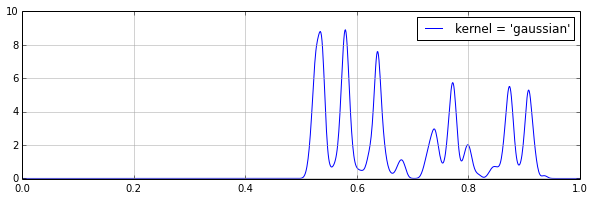

[0.534, 0.579, 0.636, 0.679, 0.738, 0.771, 0.798, 0.846, 0.873, 0.907, 0.935]

In [98]:
X_range = 1
X_plot = np.linspace(0,X_range,1000)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.005).fit(dfTumorCNV[dfTumorCNV.mBAFCount>10].mBAF.sort_values()[:, np.newaxis])
log_dens = kde.score_samples(X_plot)
pdfChart(log_dens,10)
mBAFPeaks = findPeaks(log_dens,X_range)
mBAFPeaks

In [99]:
dfTumorCNV['fittedBAFPeak'] = np.vectorize(fitBAFPeak)(dfTumorCNV['mBAF'])
dfTumorCNV['fittedCNVPeak'] = np.vectorize(fitCNVPeak)(dfTumorCNV['ratioOfRatio'])
pd.pivot_table(dfTumorCNV, values='mBAFCount', index=['fittedBAFPeak'], columns=['fittedCNVPeak'], aggfunc='sum',margins=True).fillna("")

fittedCNVPeak,0.23,0.435,0.54,0.7,0.855,1.015,1.16,1.325,1.5,1.63,1.785,1.95,2.025,All
fittedBAFPeak,,,,,,,,,,,,,,
0.534,77,0,0,0,18574,42,1.0,20,3894,115,4,0,0,22727.0
0.579,10,,,,3,22679,7.0,1,56,7,517,1,,23281.0
0.636,,,,221,,19,11002.0,20,2,,,,,11264.0
0.679,,,,,,11,27.0,643,,,,,,681.0
0.738,,,,,1,2526,33.0,3,,,,,,2563.0
0.771,1,,18,,,2,4633.0,,,,,,,4654.0
0.798,1,,5011,,,2,39.0,,,,,,,5053.0
0.846,,,,4663,44,,2.0,,,,,,,4709.0
0.873,,1,,12,5850,,2.0,,,,,,,5865.0


### GENE CNV ANALYSIS

In [79]:
# BEST ESTIMATE OF COPY NUMBER!
purity = 0.6
CNVNormalisationFactor = 0.535
dfTumorCNV["myCopyNum"] = np.round((dfTumorCNV.fittedCNVPeak-CNVNormalisationFactor)/CNVNormalisationFactor/purity*2+2,0)

In [80]:
# LOAD CNV BED
CNV_BED_PATH = "/Users/peterpriestley/hmf/analyses/slices/"
CNV_BED_FILE_NAME = "HMF_slicing.bed"
CNVBed = aVCF.loadBEDFile(CNV_BED_PATH,CNV_BED_FILE_NAME)
GENECNV_COLUMNS = ['patientName','gene','chrom','posStart','posEnd','minCopyNum','cnvLabel']

In [92]:
dfGeneCNV = pd.DataFrame(runGeneCNVAnalysis(dfTumorCNV,CNVBed,patientID),columns= GENECNV_COLUMNS)

In [100]:
(dfGeneCNV[dfGeneCNV.minCopyNum>8])

,patientName,gene,chrom,posStart,posEnd,minCopyNum,cnvLabel
109,CPCT02010292,ENST00000373578.2 (SRC),20,35974557,36034453,9.0,amplification


### SCRATCH - TUMOR PURITY

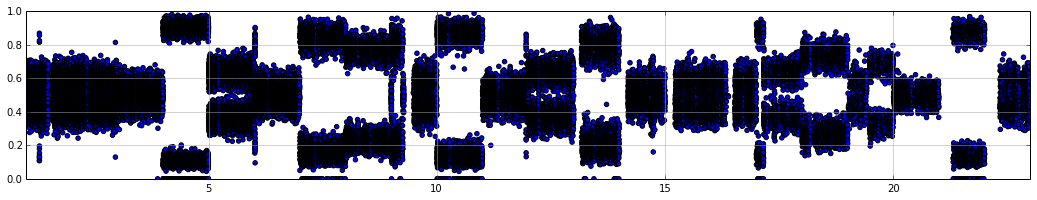

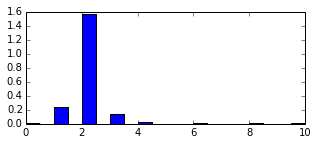

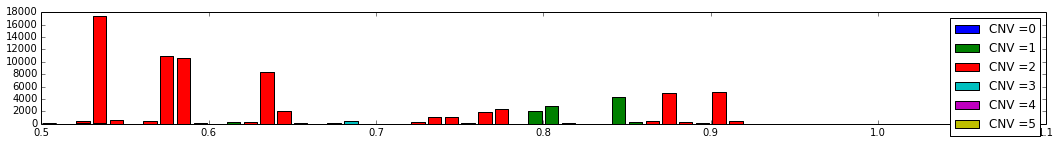

In [94]:
c, fractionMin, fractionMax = 1,0,22
dfSom = dfBAF[(dfBAF.chromPos>c+fractionMin)&(dfBAF.chromPos<c+fractionMax)]
AFByPosPlot(dfSom.chromPos, dfSom.BAF,c+fractionMin, c+fractionMax)
# CNV according to freeC
plt.figure(figsize=[5,2])
plt.hist(dfTumorCNV['copyNum'].values,cumulative=False, normed=True, bins=20,range=(0,10),weights=dfTumorCNV['regionLength'].values)
plt.show()
# should only use regions with mbaf > x
dftemp = dfTumorCNV[(dfTumorCNV.mBAF>=0.0)&(dfTumorCNV.mBAF<=1.0)&(dfTumorCNV.mBAFCount>20)&(dfTumorCNV.chromPos<=c+fractionMax)&(dfTumorCNV.chromPos>=c+fractionMin)]
plt.figure(figsize=[18,2])
for CNV in range(0,6):
    plt.hist(dftemp[(dftemp.copyNum==CNV)]['mBAF'].values,cumulative=False, normed=False, bins=50,range=(0.5,1.0),weights=dftemp[(dftemp.copyNum==CNV)]['mBAFCount'].values,stacked = True,rwidth=0.8,label='CNV ='+str(CNV))
    plt.legend()
plt.show()

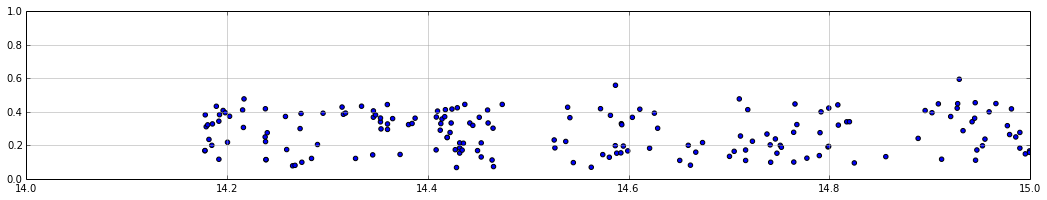

In [69]:
#&(dfSomatic['inPON']==False
c,fractionMin,fractionMax = 14,0,1
dfSom = dfSomatic[(dfSomatic['variantType']=="SNP")&(dfSomatic['consensus']==True)&(dfSomatic['inPON']==False)&(dfSomatic.chromFrac>c+fractionMin)&(dfSomatic.chromFrac<c+fractionMax)]
AFByPosPlot(dfSom.chromFrac, dfSom.meltedAF,c+fractionMin, c+fractionMax)

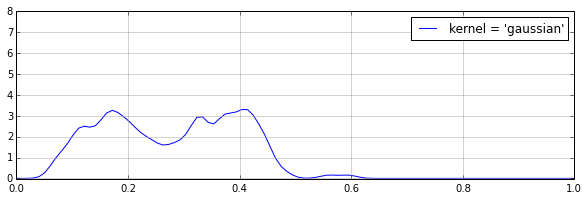

[0.12, 0.17, 0.33, 0.4, 0.56, 0.59]

In [70]:
X = dfSom.meltedAF.sort_values()[:, np.newaxis]
X_plot = np.linspace(0,1,100)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.015).fit(X)
log_dens = kde.score_samples(X_plot)
pdfChart(log_dens)
findPeaks(log_dens,1)

### Fitting

In [78]:
CNVRatioWeightFactor = 0.1
fitResults = []
for purity in np.linspace(0.55,0.8,6):
    for CNVNormalisationFactor in np.linspace(0.5,0.9,9):
        modelDeviation = 0
        for i in range(1, dfTumorCNV.shape[0]-1):
            if dfTumorCNV.iloc[i].mBAFCount > 0 and  dfTumorCNV.iloc[i].tumorRatio >= 0 : #
                # Should also correct for mBAF < 0.5
                minDeviation,bestFittedBAF,fittedPloidy = 1e9,0,0   #reset variables
                for ploidy in range(1,10):
                    modelCNVratio = CNVNormalisationFactor + (ploidy-2)*purity*CNVNormalisationFactor/2
                    CNVDeviation = CNVRatioWeightFactor*abs(modelCNVratio-dfTumorCNV.iloc[i].tumorRatio)
                    for BAF in range(int(math.ceil(ploidy/2.0)),ploidy+1):
                        modelBAF = (1+purity*(BAF-1))/(2+purity*(ploidy-2))
                        if minDeviation > abs(modelBAF-dfTumorCNV.iloc[i].mBAF) + CNVDeviation:
                            minDeviation = abs(modelBAF-dfTumorCNV.iloc[i].mBAF) + CNVDeviation
                            bestFittedBAF = modelBAF
                            fittedPloidy = ploidy
                #print bestFittedBAF,fittedPloidy,dfTumorCNV.iloc[i].mBAF,dfTumorCNV.iloc[i].mBAFCount,minDeviation
                modelDeviation = modelDeviation + dfTumorCNV.iloc[i].mBAFCount*minDeviation
        print purity,CNVNormalisationFactor, modelDeviation
        fitResults.append([purity,CNVNormalisationFactor, modelDeviation])
dfFitOutput = pd.DataFrame(sorted(fitResults, key=lambda x: x[2]))
dfFitOutput.columns = ["purity","NormFactor",'score']
dfFitOutput

0.55 0.5 1925.78262365
0.55 0.55 1541.21615268
0.55 0.6 2167.73130831
0.55 0.65 2867.70650995
0.55 0.7 3385.95098105
0.55 0.75 3618.43990604
0.55 0.8 3638.67365461
0.55 0.85 3745.92739227
0.55 0.9 3988.9852564
0.6 0.5 1471.16063322
0.6 0.55 1277.30137994
0.6 0.6 1987.84899218
0.6 0.65 2678.44310516
0.6 0.7 3180.38076562
0.6 0.75 3481.3844463
0.6 0.8 3511.34731659
0.6 0.85 3635.29446419
0.6 0.9 3886.38629047
0.65 0.5 1673.00344284
0.65 0.55 1933.47227841
0.65 0.6 2451.71572331
0.65 0.65 3002.6496544
0.65 0.7 3289.47016936
0.65 0.75 3465.40124841
0.65 0.8 3507.40257439
0.65 0.85 3645.39599067
0.65 0.9 3951.49589469
0.7 0.5 2065.02363367
0.7 0.55 2453.00398374
0.7 0.6 2880.87992806
0.7 0.65 3175.46831457
0.7 0.7 3354.77271864
0.7 0.75 3401.45790478
0.7 0.8 3448.818418
0.7 0.85 3407.23592456
0.7 0.9 3755.23629145
0.75 0.5 2446.49899774
0.75 0.55 2818.51177633
0.75 0.6 3200.02189809
0.75 0.65 3386.42266622
0.75 0.7 3493.27988749
0.75 0.75 3361.07238568
0.75 0.8 3325.86014967
0.75 0.85 3332.

,purity,NormFactor,score
0,0.60,0.55,1277.301380
1,0.60,0.50,1471.160633
2,0.55,0.55,1541.216153
3,0.65,0.50,1673.003443
4,0.55,0.50,1925.782624
5,0.65,0.55,1933.472278
6,0.60,0.60,1987.848992
7,0.70,0.50,2065.023634
8,0.55,0.60,2167.731308
9,0.75,0.50,2446.498998


In [ ]:
dfTumorCNV.head()

In [107]:
dfSomatic[(dfSomatic['variantType']=="SNP")&(dfSomatic['consensus']==True)&(dfSomatic['inPON']==False)&(dfSomatic.annGene<>'')&((dfSomatic.annWorstImpact=='MODERATE'))]

,chrom,pos,chromPos,chromFrac,id,ref,vennSegment,numCallers,variantType,variantSubType,filter,bedRegion,inDBSNP,inCOSMIC,annGene,annWorstImpact,annWorstEffect,annAllEffects,consensus,meltedallele,meltedAF,meltedDP,meltedQS,meltedSGT,meltedindelDiff,meltedSVLenMin,meltedSVLenMax,meltedSVStartMin,meltedSVStartMax,patientName,alt,PONCount,inPON
2166,1,153234011,1:153234011,1.614779,rs142603426;COSM4169128,T,freebayes-mutect,2,SNP,,PASS,Default,True,True,LOR,MODERATE,missense_variant,missense_variant,True,G,0.158537,83,-1.0,0/1,,,,,,CPCT02070067,G,0,False
6582,3,14106332,3:14106332,3.071236,rs113667859;COSM4157326,G,varscan-freebayes-mutect,3,SNP,,PASS,,True,True,TPRXL,MODERATE,missense_variant,missense_variant|missense_variant|missense_var...,True,C,0.333333,123,-1.0,0/1,,,,,,CPCT02070067,C,2,False
19758,9,17135364,9:17135364,9.121344,.,C,strelka-freebayes,2,SNP,,PASS,Default,False,False,CNTLN,MODERATE,missense_variant,missense_variant|missense_variant|missense_var...,True,T,0.243902,127,-1.0,0/1,,,,,,CPCT02070067,T,0,False
38294,X,46434339,X:46434339,23.299054,.,G,freebayes-mutect,2,SNP,,PASS,Default,False,False,CHST7,MODERATE,missense_variant,missense_variant|sequence_feature,True,T,0.086957,46,-1.0,0/1,,,,,,CPCT02070067,T,0,False


In [112]:
pd.pivot_table(dfSomatic[dfSomatic.consensus == True], values='pos', index=['patientName','variantType','inDBSNP'], columns=['inPON'], aggfunc='count',margins=False).fillna("")

inPON                             False  True 
patientName  variantType inDBSNP              
CPCT02070067 INDEL       False       73    328
                         True        38    231
             SNP         False      223    627
                         True        33    100